In [1]:
%cd ..


/Users/eliaweiss/ai/segmentation/MobileSAM


In [2]:
import cv2
import numpy as np
from tblDetect.TableDetect import TableDetect
from tblDetect.MobileSamBoxes import MobileSamBoxes
import matplotlib.pyplot as plt
from PIL import Image
from notebooks.Utils import plot_results, plot_annotations, \
    plot_rotatedResult,outputs_to_objects, \
        calculate_angle
import torch        
desired_dtype = torch.bfloat16
# torch.set_default_dtype(desired_dtype)    # .to(torch.bfloat16)     

/Users/eliaweiss/ai/segmentation/MobileSAM/tinyvit/tiny_vit.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with tinyvit.tiny_vit.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/eliaweiss/ai/segmentation/MobileSAM/tinyvit/tiny_vit.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with tinyvit.tiny_vit.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/eliaweiss/ai/segmentation/MobileSAM/tinyvit/tiny_vit.py:656: UserWarning: Overwriting tiny_vit_21m_224 in registry with tinyvit.tiny_vit.tiny_vit_21m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/eliaweiss/ai/segmentation/MobileSAM/tinyvit/tiny_vit.py:656: U

In [3]:
# file_path = "./app/assets/picture1.jpg"
# file_path = "/Users/eliaweiss/Documents/doc2txt/sihach/attachments/img/20231025012642_001.jpg"
file_path = "/Users/eliaweiss/Documents/doc2txt/sihach/need fix/4e7d4235deff4ee2b72d886e12ad0bcf.jpg"
# file_path = "/Users/eliaweiss/Documents/doc2txt/invoices 2/expense (6).jpeg"
# file_path = "/Users/eliaweiss/Documents/doc2txt/lineCv/1/12.png"

img = Image.open(file_path)
max_size = (1000, 1000)  # Example maximum size

# Resize the image
img.thumbnail(max_size)

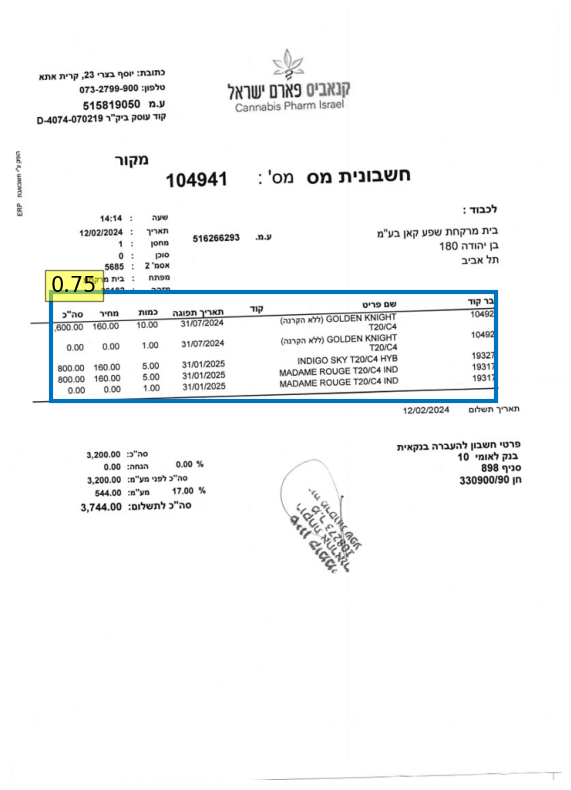

In [4]:
tblDec = TableDetect()
probas, boxes = tblDec.detectTables(img)
plot_results(tblDec.model, img, probas, boxes)


# Crop table with sam

checkpoint_load_scucess


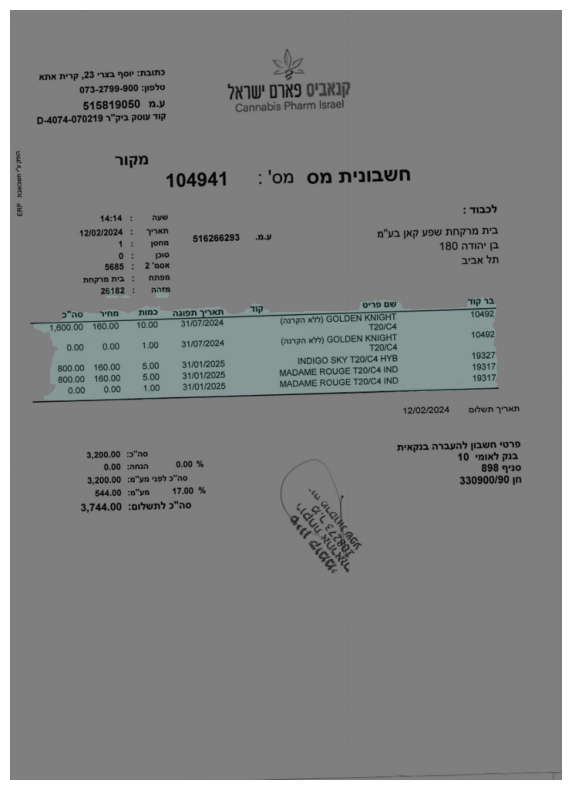

In [7]:
sam = MobileSamBoxes()
anns = sam.process(img,boxes)
plot_annotations(img, anns)

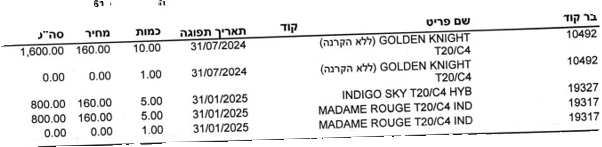

In [51]:
from PIL import Image
import cv2

def create_mask_patch(image, mask):
  """
  Creates a patch from the image containing only the mask region.

  Args:
      image: A PIL image object.
      mask: A NumPy array representing the mask (1 for mask pixels).

  Returns:
      A PIL image object containing the patch from the original image 
      with only the mask region and white background for non-mask pixels.
  """
  mask=mask.cpu().numpy()
  # mask = cv2.dilate(mask, np.ones((13, 13), np.uint8), iterations=1)  
  # Find non-zero elements (mask pixels) in the mask
  mask_coords = np.where(mask != 0)

  # Get minimum and maximum coordinates from the mask pixels
  min_y, min_x = mask_coords[0].min(), mask_coords[1].min()
  max_y, max_x = mask_coords[0].max() + 1, mask_coords[1].max() + 1  # Add 1 for inclusive range

  # Create the bounding box rectangle
  bounding_box = (min_x, min_y, max_x, max_y)


  mask = mask==1
  imgArr = np.array(image)
  imgArr[~mask] = (255,255,255)
  image = Image.fromarray(imgArr)
  # color_mask = np.concatenate([np.random.random(3), [1]])
  # img[m] = color_mask
  # Crop the image using the bounding box
  patch_image = image.crop(bounding_box)
  return patch_image

# Example usage
mask = anns[0]

tbl_patch = create_mask_patch(img, mask)
# patch.show()  # Display the created patch
tbl_patch


# Table structure recognition

In [9]:
from transformers import DetrFeatureExtractor

feature_extractor = DetrFeatureExtractor()
encoding = feature_extractor(tbl_patch, return_tensors="pt")
encoding.keys()

/Users/eliaweiss/opt/anaconda3/envs/mobileSam/lib/python3.10/site-packages/transformers/models/detr/feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(


dict_keys(['pixel_values', 'pixel_mask'])

In [10]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
from transformers import TableTransformerForObjectDetection

# new v1.1 checkpoints require no timm anymore
structure_model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-structure-recognition-v1.1-all")
structure_model.to(device)
""

''

In [12]:
from torchvision import transforms

class MaxResize(object):
    def __init__(self, max_size=800):
        self.max_size = max_size

    def __call__(self, image):
        width, height = image.size
        current_max_size = max(width, height)
        scale = self.max_size / current_max_size
        resized_image = image.resize((int(round(scale*width)), int(round(scale*height))))

        return resized_image
structure_transform = transforms.Compose([
    MaxResize(1000),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [13]:
pixel_values = structure_transform(tbl_patch).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 244, 1000])


In [14]:
# forward pass
with torch.no_grad():
  outputs = structure_model(pixel_values)

In [15]:
# update id2label to include "no object"
structure_id2label = structure_model.config.id2label
structure_id2label[len(structure_id2label)] = "no object"

cells = outputs_to_objects(outputs, tbl_patch.size, structure_id2label)
print(cells)

[{'label': 'table column', 'score': 0.9983194470405579, 'bbox': [69.28837585449219, 10.726980209350586, 120.45584869384766, 137.0491485595703]}, {'label': 'table column', 'score': 0.9990062117576599, 'bbox': [303.9319152832031, 10.697382926940918, 517.6673583984375, 136.96583557128906]}, {'label': 'table row', 'score': 0.9627853035926819, 'bbox': [19.887165069580078, 28.277658462524414, 599.2047729492188, 57.45429992675781]}, {'label': 'table column', 'score': 0.9996494054794312, 'bbox': [518.4161987304688, 10.75120735168457, 599.2840576171875, 137.1336212158203]}, {'label': 'table column header', 'score': 0.971786618232727, 'bbox': [19.985410690307617, 10.83173942565918, 599.1284790039062, 28.32103157043457]}, {'label': 'table row', 'score': 0.9945843815803528, 'bbox': [19.810791015625, 57.30831527709961, 599.1643676757812, 84.687255859375]}, {'label': 'table row', 'score': 0.997844934463501, 'bbox': [19.988693237304688, 108.22258758544922, 599.1279907226562, 122.6690902709961]}, {'la

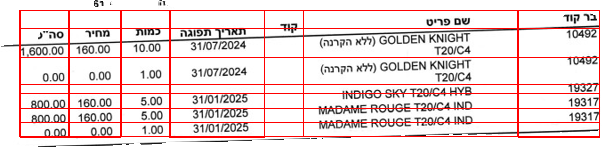

In [16]:
from PIL import ImageDraw

cropped_table_visualized = tbl_patch.copy()
draw = ImageDraw.Draw(cropped_table_visualized)

for cell in cells:
    draw.rectangle(cell["bbox"], outline="red")

cropped_table_visualized

In [17]:
def plot_results_cells(tbl_patch, cells, class_to_visualize):
    if class_to_visualize not in structure_model.config.id2label.values():
      raise ValueError(f"Class should be one of the available classes {structure_model.config.id2label}")

    plt.figure(figsize=(16,10))
    plt.imshow(tbl_patch)
    ax = plt.gca()

    for cell in cells:
        bbox = cell["bbox"]
        label = cell["label"]

        if label == class_to_visualize:
          xmin, ymin, xmax, ymax = tuple(bbox)

          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color=np.random.random(3), linewidth=3))
          plt.axis('off')

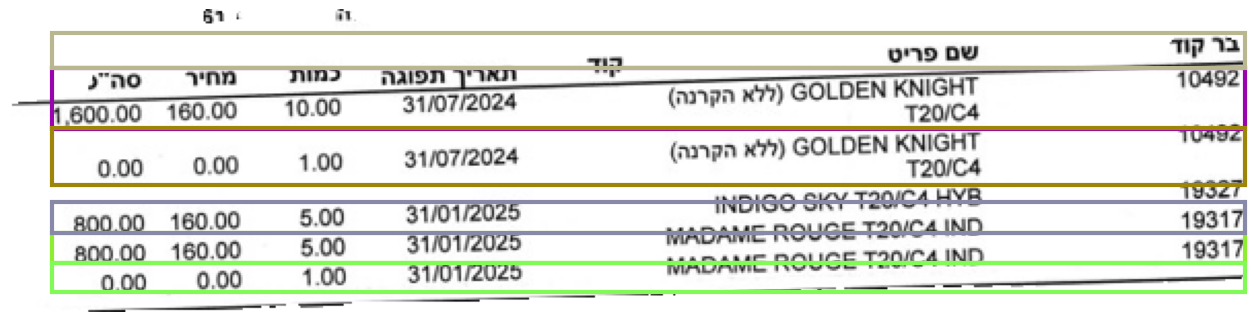

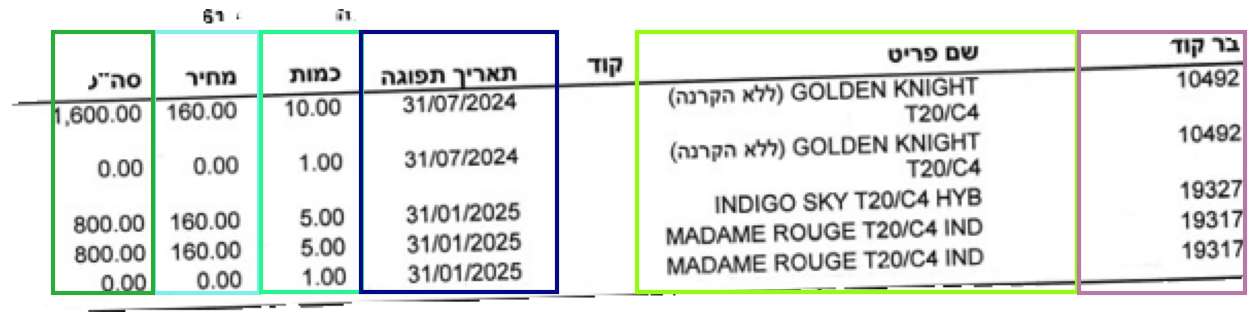

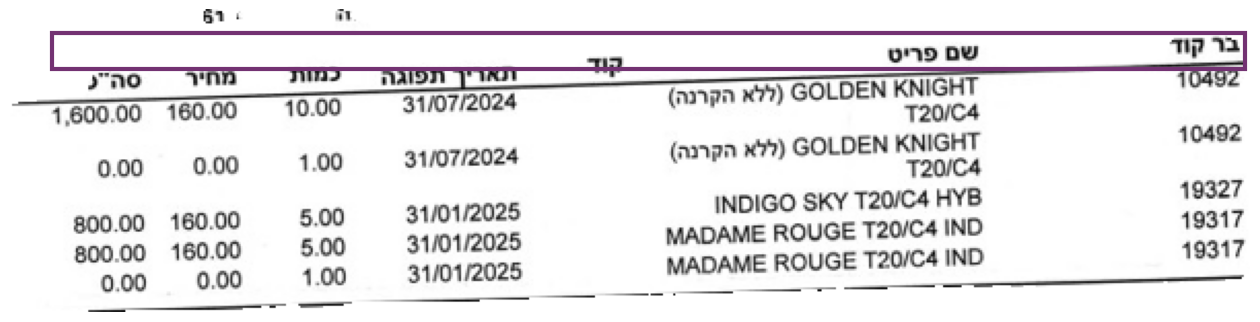

In [18]:
plot_results_cells(tbl_patch,cells, class_to_visualize="table row")
plot_results_cells(tbl_patch, cells, class_to_visualize="table column")
plot_results_cells(tbl_patch,cells, class_to_visualize="table column header")
# plot_results_cells(tbl_patch,cells, class_to_visualize="table projected row header")
# plot_results_cells(tbl_patch,cells, class_to_visualize="table spanning cell")

# align table

In [52]:
m = anns[0].bool()
m=m.cpu().numpy()
mask = np.zeros((anns.shape[1], anns.shape[2], 1), np.uint8)
mask[m] = 255
# mask = ~mask
print(mask.shape)
print(mask.dtype)

(1000, 716, 1)
uint8


In [55]:
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour = None
rectArea = None
for c in contours:
    _,_,h,w =cv2.boundingRect(c)
    if rectArea is None or rectArea < h*w:
        rectArea = h*w
        contour = c
        
    print(h*w)
rectArea  
# len(contours)

81270
124
12
221
77


81270

In [54]:
image = np.array(img)

19 400


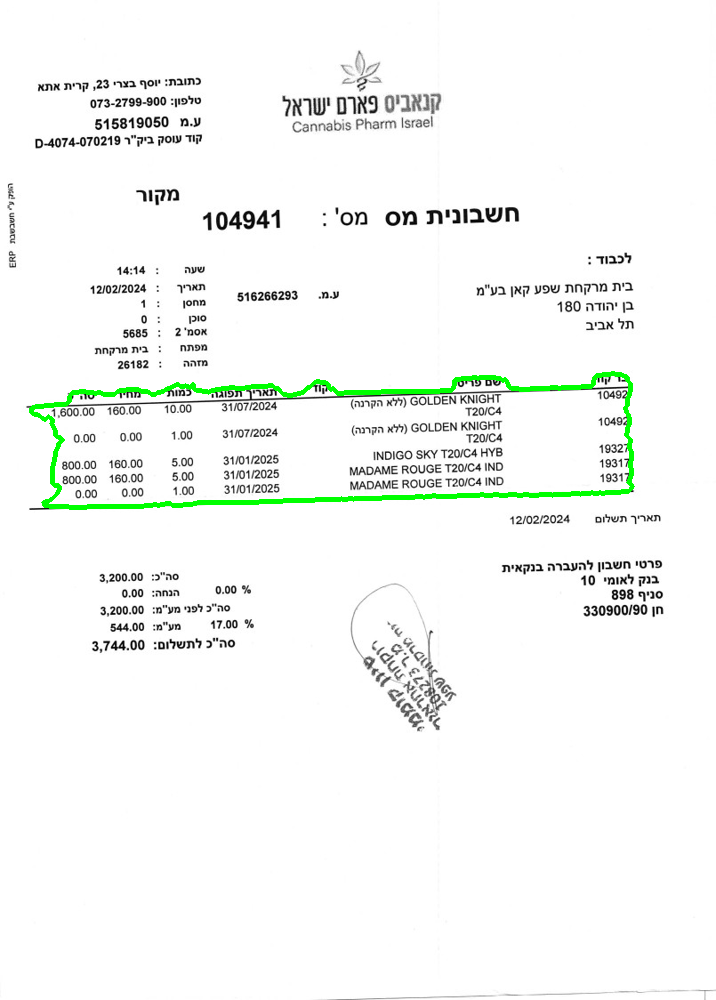

In [65]:
tmpImg = image.copy()
perimeter = cv2.arcLength(contour, True)

# Set the epsilon parameter for approxPolyDP
epsilon = 0.005 * perimeter

# Approximate the contour with a polygon
approx = cv2.approxPolyDP(contour, epsilon, True)
print(len(approx),len(contour))
cv2.drawContours(tmpImg, [contour], 0, (0, 255, 0), 4)  # Green bounding box with thickness 2
Image.fromarray(tmpImg)

In [22]:
def calcBB():
    mask_coords = np.where(mask != 0)

# Get minimum and maximum coordinates from the mask pixels
    min_y, min_x = mask_coords[0].min(), mask_coords[1].min()
    max_y, max_x = mask_coords[0].max() + 1, mask_coords[1].max() + 1  # Add 1 for inclusive range

# Define the dimensions of the output rectangle
    width = max_x-min_x  # Define your desired width here
    height = max_y-min_y  # Define your desired height here
    return (min_x, max_x), (min_y, max_y), (width,height)



In [23]:
def linear_interpolation_midpoint(p1,p2):
  (x1, y1) = p1
  (x2, y2) = p2
  # Calculate the slopes in x and y directions
  slope_x = (x2 - x1) / 2
  slope_y = (y2 - y1) / 2

  # Calculate the midpoint coordinates
  midpoint_x = x1 + slope_x
  midpoint_y = y1 + slope_y

  return midpoint_x, midpoint_y

In [24]:
def find_closest_point_in_contour(contour, point_xy):
   min_dist = np.inf
   closest_point = None

   for contour_point in contour:
       x, y = contour_point[0]
       dist = np.sqrt((x - point_xy[0])**2 + (y - point_xy[1])**2)
       if dist < min_dist:
           min_dist = dist
           closest_point = x, y

   return closest_point
#    return linear_interpolation_midpoint(closest_point,point_xy)

def approxBoundingQuadrilateral(find_closest_point_in_contour):
    (min_x, max_x), (min_y, max_y), (width,height) = calcBB()
    lb = find_closest_point_in_contour(contour, (min_x,min_y))
    lt = find_closest_point_in_contour(contour, (min_x,max_y))
    rt = find_closest_point_in_contour(contour, (max_x,max_y))
    rb = find_closest_point_in_contour(contour, (max_x,min_y))
    # return clock wise
    return (lb,rb, rt, lt), (width,height)

boundingQuadrilateral, (width,height) = approxBoundingQuadrilateral(find_closest_point_in_contour)
boundingQuadrilateral

((35, 406), (626, 376), (628, 491), (44, 505))

In [25]:
(min_x, max_x), (min_y, max_y), (width,height) = calcBB()


In [26]:
print((min_x,min_y))
find_closest_point_in_contour(contour, (min_x,min_y))

(31, 361)


(35, 406)

In [27]:
print((max_x,min_y))
find_closest_point_in_contour(contour, (max_x,min_y))

(633, 361)


(626, 376)

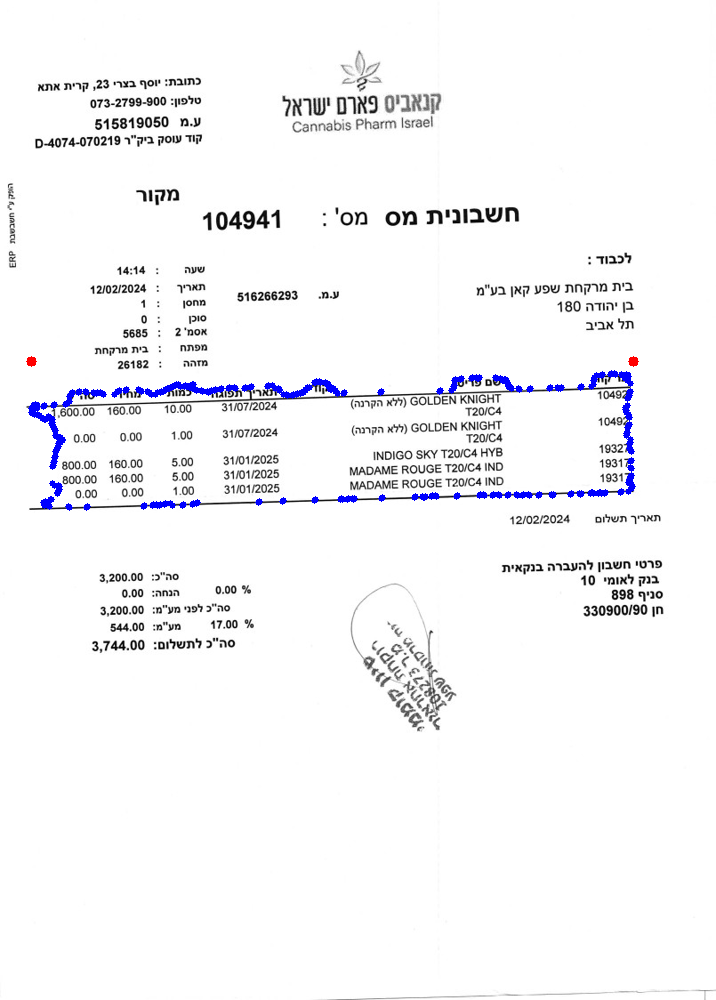

In [28]:
(min_x, max_x), (min_y, max_y), (width,height) = calcBB()
(min_x, max_x), (min_y, max_y), (width,height)
tmpImg = image.copy()
cv2.circle(tmpImg, (min_x,min_y), radius=5, color=(255,0, 0), thickness=-1)  # Red circles
cv2.circle(tmpImg, (max_x,min_y), radius=5, color=(255,0, 0), thickness=-1)  # Red circles

cv2.circle(tmpImg, boundingQuadrilateral[0], radius=5, color=(0, 0,255), thickness=-1)  # Red circles
cv2.circle(tmpImg, boundingQuadrilateral[1], radius=5, color=(0, 0,255), thickness=-1)  # Red circles

for pt in contour:
    cv2.circle(tmpImg, pt[0], radius=3, color=(0, 0,255), thickness=-1)  # Red circles
    
Image.fromarray(tmpImg)

In [29]:
lb,rb,_,_ = boundingQuadrilateral
mask_coords = np.array( [lb,rb])
mask_coords


array([[ 35, 406],
       [626, 376]], dtype=int32)

In [30]:
mask_coords = mask_coords.T
mask_coords

array([[ 35, 626],
       [406, 376]], dtype=int32)

In [31]:
print(mask_coords[0].min())
print(mask_coords[0].max())
print(mask_coords[1].min())
print(mask_coords[1].max())

35
626
376
406


In [32]:
# Get minimum and maximum coordinates from the mask pixels
l, r  = mask_coords[0].min(), mask_coords[0].max()
b, t = mask_coords[1].min()+1, mask_coords[1].max()+1
bbox = [(int(l),int(b)), (int(r), int(t))]
bbox

[(35, 377), (626, 407)]

In [33]:

points = contour.squeeze()
points.shape 

(400, 2)

In [34]:

def find_points_in_bbox(bbox, points):
 """
 Finds all points within a given bounding box.

 Args:
   bbox: A list of two tuples representing the top-left and bottom-right corners of the bounding box.
     Ex: [(left, bottom), (top, right)]
   points: A list of tuples representing the points to check.
     Ex: [(x1, y1), (x2, y2), ...]

 Returns:
   A list of points that are within the bounding box.
 """

 l, b = bbox[0]  # Extract left and bottom coordinates
 r, t = bbox[1]  # Extract top and right coordinates

 points_inside = []
 for x, y in points:
   if l <= x <= r and b <= y <= t:  # Check if point is within bbox boundaries
     points_inside.append((x, y))

 return points_inside

points_inside = find_points_in_bbox(bbox, points)
points_inside.insert(0,bbox[0])
points_inside.insert(-1,bbox[1])
len(points_inside)

186

In [35]:
slopes = []
diff = []
for p1,p2 in zip(points_inside[0:-2],points_inside[1:]):
    x1,y1 = p1
    x2,y2 = p2
    if x1-x2 == 0:
        continue
    slope = (y2-y1)/(x1-x2+1e-16)
    slopes.append(slope)
    diff.append(x1-x2+1e-16)

In [36]:
mean = np.mean(slopes)

# Calculate standard deviation using numpy.std
standard_deviation = np.std(slopes)
mean, standard_deviation

(0.10118040447989687, 0.7289919131634882)

In [37]:
slopes_filtered = [v for v in slopes if abs(v)<=standard_deviation]

In [38]:
mean2 = np.mean(slopes_filtered)
mean2

-2.1974641263981366e-05

In [39]:
calculate_angle(mean2)


-0.0012590542005374975

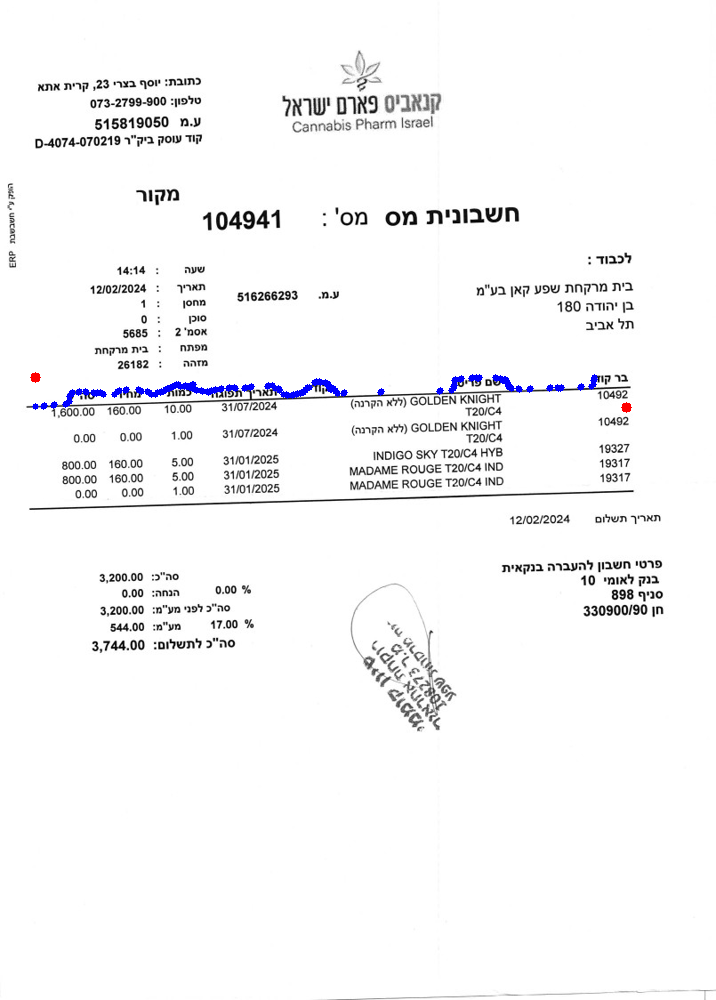

In [40]:
tmpImg = image.copy()
# Iterate through points and draw them on the image
for point in points_inside:
    cv2.circle(tmpImg, point, radius=3, color=(0, 0, 255), thickness=-1)  # Red circles
cv2.circle(tmpImg, bbox[0], radius=5, color=(255,0, 0), thickness=-1)  # Red circles
cv2.circle(tmpImg, bbox[1], radius=5, color=(255,0, 0), thickness=-1)  # Red circles

Image.fromarray(tmpImg)

In [41]:

def find_approximate_line(points_inside):
    """
    Finds the approximate line using linear regression for a given set of points.

    Args:
        points_inside: A list of tuples representing the points to fit the line to.

    Returns:
        A tuple containing the slope and intercept of the estimated line.
    """

    x_vals = [point[0] for point in points_inside]
    y_vals = [point[1] for point in points_inside]

    # Use numpy's polyfit function for linear regression
    slope, intercept = np.polyfit(x_vals, y_vals, 1)

    return slope, intercept

slope, intercept = find_approximate_line(points_inside)

print("Approximate line: y = {}x + {}".format(slope, intercept))

Approximate line: y = -0.01869561525445829x + 393.8199753097957


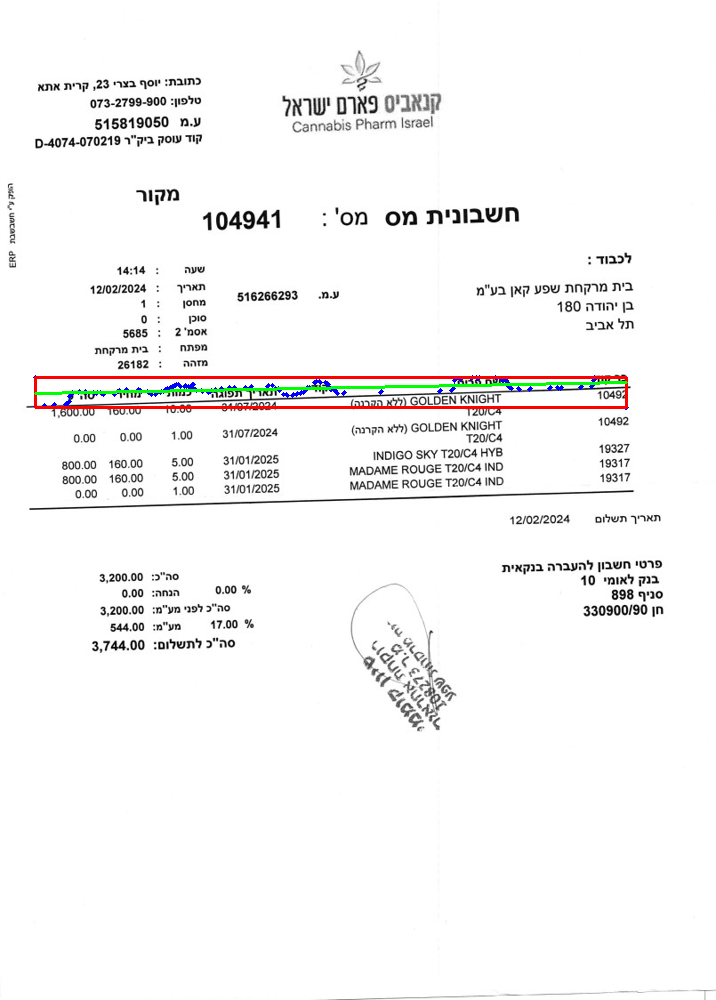

In [42]:

def draw_line_on_image(img, points_inside, bbox):
  """
  Draws the approximate line and bounding box on the image.

  Args:
      img: The image as a NumPy array.
      points_inside: A list of tuples representing points inside the bounding box.
      bbox: A list of two tuples representing the top-left and bottom-right corners of the bounding box.
  """

  # Find approximate line
  slope, intercept = find_approximate_line(points_inside)

  # Calculate line endpoints for visualization (assuming image width is in img.shape[1])
  x1 = bbox[0][0]  # Left edge of bounding box
  y1 = int(slope * x1 + intercept)  # Calculate y-coordinate for x1 using the line equation
  x2 = bbox[1][0]  # Right edge of bounding box
  y2 = int(slope * x2 + intercept)  # Calculate y-coordinate for x2 using the line equation

  # Draw points
  for point in points_inside:
      cv2.circle(img, point, radius=2, color=(0, 0, 255), thickness=-1)  # Red circles

  # Draw bounding box
  cv2.rectangle(img, bbox[0], bbox[1], color=(255, 0, 0), thickness=2)  # Blue rectangle

  # Draw line
  cv2.line(img, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)  # Green line

tmpImg = image.copy()
# Draw line and bounding box on the image
draw_line_on_image(tmpImg, points_inside, bbox)

Image.fromarray(tmpImg)

In [43]:
def calculate_angle(slope):
    """
    Calculates the angle of the line relative to the x-axis in degrees.

    Args:
    slope: The slope of the estimated line.

    Returns:
    The angle of the line in degrees.
    """

    # Use arctangent (atan) to find the angle in radians
    radians = np.arctan(slope)

    # Convert radians to degrees
    angle_in_degrees = np.rad2deg(radians)

    return angle_in_degrees
angle = calculate_angle(slope)
angle

-1.0710550739005604

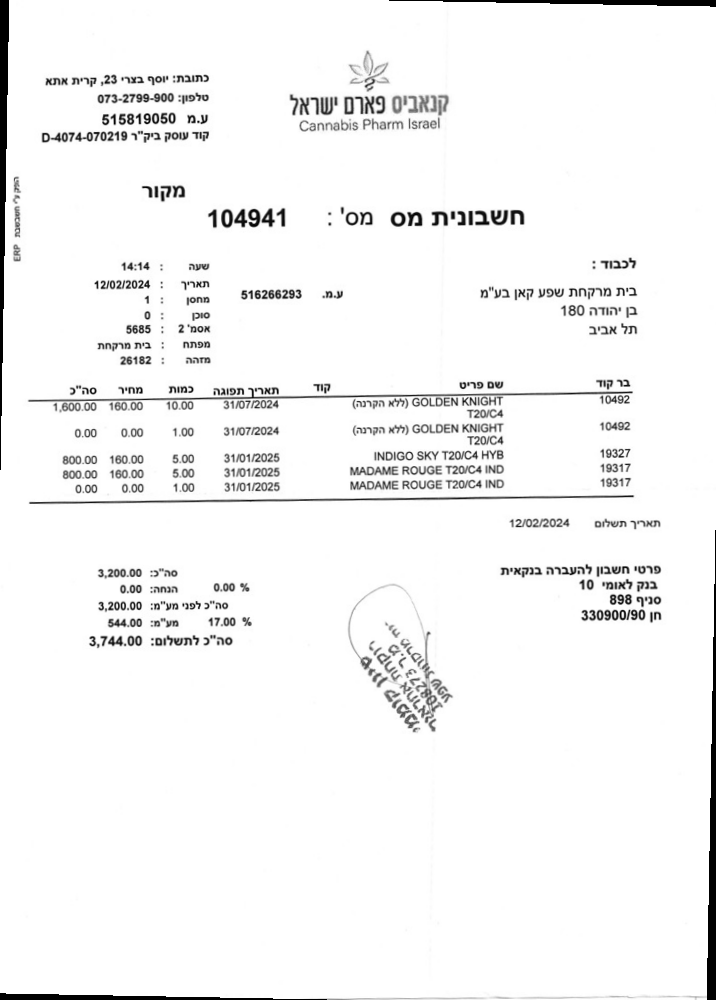

In [44]:
# tmpImg2 = Image.fromarray(tmpImg)
tmpImg2 = Image.fromarray(image.copy())
tmpImg2 =  tmpImg2.rotate(angle, resample=Image.BILINEAR)
tmpImg2

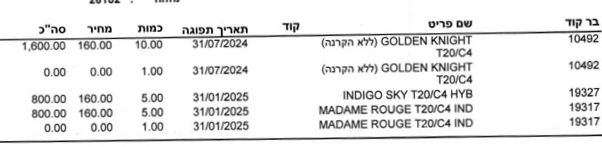

In [45]:
(min_x, max_x), (min_y, max_y), (width,height) = calcBB()

alignTable = tmpImg2.crop([min_x, min_y,max_x, max_y])
alignTable

# Find cell from align tbl

In [46]:
pixel_values = structure_transform(alignTable).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 244, 1000])


In [47]:
# forward pass
with torch.no_grad():
  outputs = structure_model(pixel_values)

In [48]:
# update id2label to include "no object"
structure_id2label = structure_model.config.id2label
structure_id2label[len(structure_id2label)] = "no object"

cells = outputs_to_objects(outputs, alignTable.size, structure_id2label)
print(cells)

[{'label': 'table column', 'score': 0.9988346695899963, 'bbox': [70.21727752685547, 15.009819030761719, 122.2125015258789, 132.91427612304688]}, {'label': 'table column', 'score': 0.9992947578430176, 'bbox': [308.3046875, 15.09585189819336, 519.201171875, 132.6549530029297]}, {'label': 'table row', 'score': 0.904886782169342, 'bbox': [20.853431701660156, 31.744935989379883, 599.07763671875, 62.34870529174805]}, {'label': 'table column', 'score': 0.999650239944458, 'bbox': [519.8897705078125, 15.10820198059082, 599.0990600585938, 132.78704833984375]}, {'label': 'table column header', 'score': 0.9901325702667236, 'bbox': [20.632667541503906, 15.133378028869629, 598.909423828125, 31.122940063476562]}, {'label': 'table row', 'score': 0.9362305402755737, 'bbox': [20.896921157836914, 59.30854415893555, 598.8050537109375, 89.23655700683594]}, {'label': 'table row', 'score': 0.993386447429657, 'bbox': [20.71758270263672, 103.55274963378906, 598.960693359375, 118.04292297363281]}, {'label': 'ta

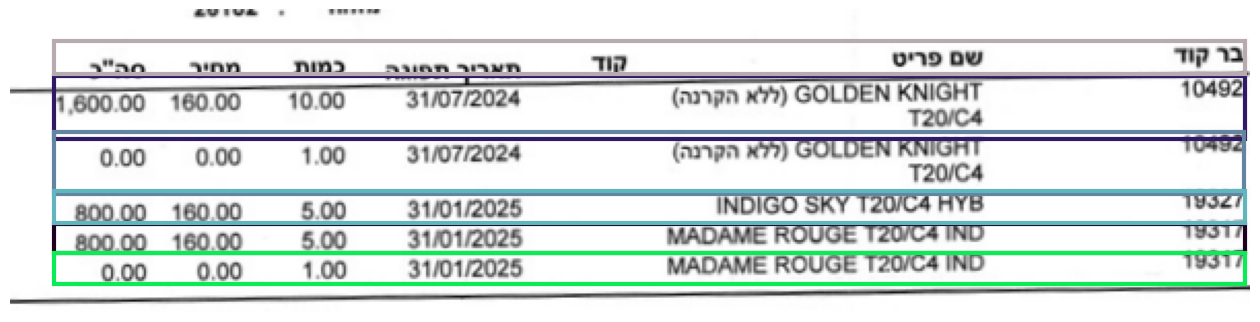

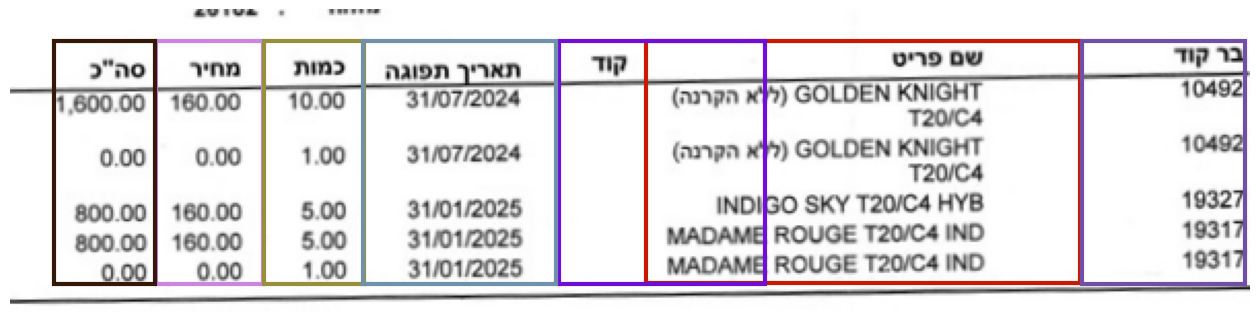

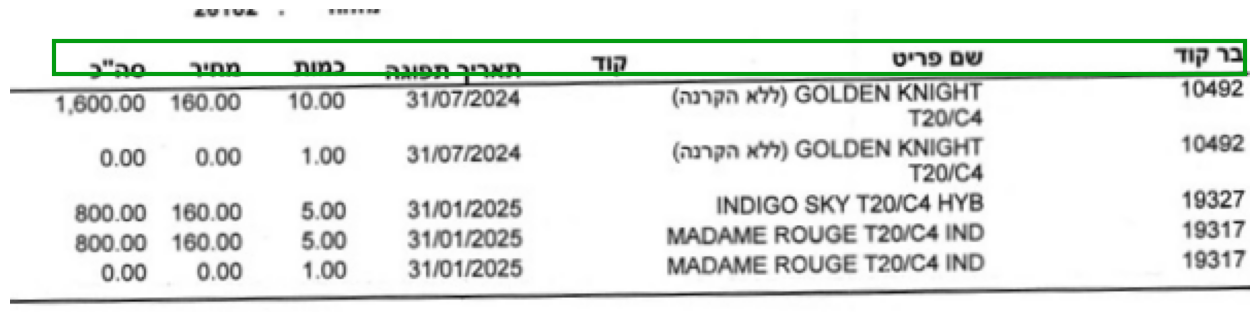

In [49]:
plot_results_cells(alignTable,cells, class_to_visualize="table row")
plot_results_cells(alignTable, cells, class_to_visualize="table column")
plot_results_cells(alignTable,cells, class_to_visualize="table column header")

# quanto

In [ ]:
# import quanto
# from quanto import quantize, freeze
# quantize(tblDec.model, weights=quanto.qint8, activations=None)
# freeze(tblDec.model)
# def print_param_dtype(model):
#     for name, param in model.named_parameters():
#         print(f"{name} is loaded in {param.dtype}")
# print_param_dtype(tblDec.model)
# fp32_mem_footprint = tblDec.model.get_memory_footprint()
# print("Footprint of the fp32 model in MBs: ", 
#       fp32_mem_footprint/1e+6)